### Import Library

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf

import numpy as np
import pandas as pd
import math

from sklearn.metrics import mean_squared_error as mse
from keras.losses import MeanAbsolutePercentageError

from keras.initializers import RandomUniform

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

### Import Dataset

In [2]:
df = pd.read_csv('data/data_ctm.csv')

### EDA

In [3]:
# Convert Dataset into DataFrame
# dataset = pd.DataFrame(dataset)
df.head()

,Month,Use_CTM
0,2015-01-01,6437
1,2015-02-01,7048
2,2015-03-01,8305
3,2015-04-01,7741
4,2015-05-01,7851


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Month    84 non-null     object
 1   Use_CTM  84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [5]:
df.isna().sum()

Month      0
Use_CTM    0
dtype: int64

In [6]:
df.describe()

,Use_CTM
count,84.000000
mean,7613.440476
std,553.152615
min,6389.000000
25%,7238.750000
50%,7698.000000
75%,8099.500000
max,8324.000000


In [7]:
df['Month'] = pd.to_datetime(df['Month']).dt.date
df.head()

,Month,Use_CTM
0,2015-01-01,6437
1,2015-02-01,7048
2,2015-03-01,8305
3,2015-04-01,7741
4,2015-05-01,7851


In [8]:
plot = px.line(df, x=df.Month, y=df.Use_CTM)
plot.show()

In [9]:
plot = px.histogram(df, x=df.Use_CTM, marginal='box')
plot.show()

### Data Preprocessing

In [10]:
df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M')

In [11]:
df.set_index('Month', inplace=True)
df.head()

,Use_CTM
Month,
2015-01,6437
2015-02,7048
2015-03,8305
2015-04,7741
2015-05,7851


In [12]:
df = df.values

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.0248062 ],
       [0.34056848],
       [0.99018088],
       [0.69870801],
       [0.75555556],
       [0.98087855],
       [0.40775194],
       [0.40155039],
       [0.95813953],
       [0.31472868],
       [0.91731266],
       [0.7870801 ],
       [0.13850129],
       [0.88165375],
       [0.78242894],
       [0.88372093],
       [0.94470284],
       [0.90077519],
       [0.66666667],
       [0.        ],
       [0.66976744],
       [0.81498708],
       [0.57105943],
       [0.32816537],
       [0.34005168],
       [0.68320413],
       [0.73333333],
       [0.99328165],
       [0.55090439],
       [0.73333333],
       [0.55710594],
       [0.97260982],
       [0.97260982],
       [0.85219638],
       [0.10904393],
       [0.0630491 ],
       [0.9870801 ],
       [0.6625323 ],
       [0.33436693],
       [0.94521964],
       [0.28630491],
       [0.03307494],
       [0.8878553 ],
       [0.6997416 ],
       [0.29870801],
       [0.66098191],
       [1.        ],
       [0.754

In [14]:
train_size = int(len(df) * 0.8)
test_size = (len(df)) - train_size
print(train_size, test_size)

67 17


In [15]:
train , test = df[0:train_size,:] , df[train_size:len(df),:]

In [16]:
def to_sequences(df, seq_size):
    x = []
    y = []

    for i in range(len(df)-seq_size):
        window = df[i:(i+seq_size), 0]
        x.append(window)
        y.append(df[i+seq_size, 0])

    return np.array(x), np.array(y)

In [17]:
seq_size = 5

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of testinf set: {}".format(testX.shape))

Shape of training set: (62, 5)
Shape of testinf set: (12, 5)


In [18]:
mape = MeanAbsolutePercentageError()

### Model 1

In [19]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model1.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model1.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=6)

model1.evaluate(testX, testY)


1/1 [==============================] - 0s 142ms/step - loss: 0.0306 - mean_absolute_error: 0.1497


[0.03057648427784443, 0.14970162510871887]

In [20]:
trainPredict1 = model1.predict(trainX)
testPredict1 = model1.predict(testX)

trainPredict1 = scaler.inverse_transform(trainPredict1)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict1 = scaler.inverse_transform(testPredict1)
testY_inverse = scaler.inverse_transform([testY])

print('Model 1')

trainScore1 = math.sqrt(mse(trainY_inverse[0], trainPredict1[:,0]))
print('Train score: %.2f' % (trainScore1))

testScore1 = math.sqrt(mse(testY_inverse[0], testPredict1[:,0]))
print('Test score: %.2f' % (testScore1))

1/1 [==============================] - 0s 31ms/step
Model 1
Train score: 519.85
Test score: 338.36


In [21]:
mapeTrain1 = mape(trainY_inverse, trainPredict1)
print('MAPE Train   :  ', mapeTrain1.numpy())
print('Akurasi Train: ', 100 - (mapeTrain1.numpy()))

mape1 = mape(testY_inverse, testPredict1)
print('MAPE Test    :  ', mape1.numpy())
print('Akurasi Test : ', 100 - (mape1.numpy()))

MAPE Train   :   7.0216527
Akurasi Train:  92.97834730148315
MAPE Test    :   3.9114387
Akurasi Test :  96.08856129646301


### Model 2

In [22]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model2.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model2.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=6)

model2.evaluate(testX, testY)


1/1 [==============================] - 0s 127ms/step - loss: 0.0272 - mean_absolute_error: 0.1376


[0.027193160727620125, 0.1375894397497177]

In [23]:
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)

trainPredict2 = scaler.inverse_transform(trainPredict2)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict2 = scaler.inverse_transform(testPredict2)
testY_inverse = scaler.inverse_transform([testY])

print('Model 2')

trainScore2 = math.sqrt(mse(trainY_inverse[0], trainPredict2[:,0]))
print('Train score: %.2f' % (trainScore2))

testScore2 = math.sqrt(mse(testY_inverse[0], testPredict2[:,0]))
print('Test score: %.2f' % (testScore2))

1/1 [==============================] - 0s 23ms/step
Model 2
Train score: 465.12
Test score: 319.09


In [24]:
mapeTrain2 = mape(trainY_inverse, trainPredict2)
print('MAPE Train: ', mapeTrain2.numpy())
print('Akurasi Train: ', 100 - (mapeTrain2.numpy()))

mape2 = mape(testY_inverse, testPredict2)
print('MAPE Test: ', mape2.numpy())
print('Akurasi Test: ', 100 - (mape2.numpy()))

MAPE Train:  7.196686
Akurasi Train:  92.80331420898438
MAPE Test:  3.859597
Akurasi Test:  96.14040303230286


### Model 3

In [19]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model3.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model3.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=6)

model3.evaluate(testX, testY)


1/1 [==============================] - 0s 147ms/step - loss: 0.0640 - mean_absolute_error: 0.2181


[0.06397321075201035, 0.21812967956066132]

In [20]:
trainPredict3 = model3.predict(trainX)
testPredict3 = model3.predict(testX)

trainPredict3 = scaler.inverse_transform(trainPredict3)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict3 = scaler.inverse_transform(testPredict3)
testY_inverse = scaler.inverse_transform([testY])

print('Model 3')

trainScore3 = math.sqrt(mse(trainY_inverse[0], trainPredict3[:,0]))
print('Train score: %.2f' % (trainScore3))

testScore3 = math.sqrt(mse(testY_inverse[0], testPredict3[:,0]))
print('Test score: %.2f' % (testScore3))

1/1 [==============================] - 0s 28ms/step
Model 3
Train score: 414.06
Test score: 489.42


In [21]:
mapeTrain3 = mape(trainY_inverse, trainPredict3)
print('MAPE Train: ', mapeTrain3.numpy())
print('Akurasi Train: ', 100 - (mapeTrain3.numpy()))

mape3 = mape(testY_inverse, testPredict3)
print('MAPE Test: ', mape3.numpy())
print('Akurasi Test: ', 100 - (mape3.numpy()))

MAPE Train:  7.403134
Akurasi Train:  92.59686613082886
MAPE Test:  4.523709
Akurasi Test:  95.47629117965698


### Model 4

In [28]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model4.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model4.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=6)

model4.evaluate(testX, testY)


1/1 [==============================] - 0s 155ms/step - loss: 0.0374 - mean_absolute_error: 0.1376


[0.03736799582839012, 0.1375531703233719]

In [29]:
trainPredict4 = model4.predict(trainX)
testPredict4 = model4.predict(testX)

trainPredict4 = scaler.inverse_transform(trainPredict4)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict4 = scaler.inverse_transform(testPredict4)
testY_inverse = scaler.inverse_transform([testY])

print('Model 4')

trainScore4 = math.sqrt(mse(trainY_inverse[0], trainPredict4[:,0]))
print('Train score: %.2f' % (trainScore4))

testScore4 = math.sqrt(mse(testY_inverse[0], testPredict4[:,0]))
print('Test score: %.2f' % (testScore4))

1/1 [==============================] - 0s 29ms/step
Model 4
Train score: 404.30
Test score: 374.05


In [30]:
mapeTrain4 = mape(trainY_inverse, trainPredict4)
print('MAPE Train: ', mapeTrain4.numpy())
print('Akurasi Train: ', 100 - (mapeTrain4.numpy()))

mape4 = mape(testY_inverse, testPredict4)
print('MAPE Test: ', mape4.numpy())
print('Akurasi Test: ', 100 - (mape4.numpy()))

MAPE Train:  7.4096894
Akurasi Train:  92.59031057357788
MAPE Test:  3.9501026
Akurasi Test:  96.04989743232727


### Model 5

In [31]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model5.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model5.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=250, batch_size=6)

model5.evaluate(testX, testY)


1/1 [==============================] - 0s 122ms/step - loss: 0.0581 - mean_absolute_error: 0.2074


[0.05814480781555176, 0.2073538452386856]

In [32]:
trainPredict5 = model5.predict(trainX)
testPredict5 = model5.predict(testX)

trainPredict5 = scaler.inverse_transform(trainPredict5)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict5 = scaler.inverse_transform(testPredict5)
testY_inverse = scaler.inverse_transform([testY])

print('Model 5')

trainScore5 = math.sqrt(mse(trainY_inverse[0], trainPredict5[:,0]))
print('Train score: %.2f' % (trainScore5))

testScore5 = math.sqrt(mse(testY_inverse[0], testPredict5[:,0]))
print('Test score: %.2f' % (testScore5))

1/1 [==============================] - 0s 23ms/step
Model 5
Train score: 303.23
Test score: 466.59


In [33]:
mapeTrain5 = mape(trainY_inverse, trainPredict5)
print('MAPE Train: ', mapeTrain5.numpy())
print('Akurasi Train: ', 100 - (mapeTrain5.numpy()))

mape5 = mape(testY_inverse, testPredict5)
print('MAPE Test: ', mape5.numpy())
print('Akurasi Test: ', 100 - (mape5.numpy()))

MAPE Train:  7.917606
Akurasi Train:  92.08239412307739
MAPE Test:  4.8439255
Akurasi Test:  95.15607452392578


### Model 6

In [34]:
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model6.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model6.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=6)

model6.evaluate(testX, testY)


1/1 [==============================] - 0s 118ms/step - loss: 0.0463 - mean_absolute_error: 0.1549


[0.0462973527610302, 0.1549433022737503]

In [35]:
trainPredict6 = model6.predict(trainX)
testPredict6 = model6.predict(testX)

trainPredict6 = scaler.inverse_transform(trainPredict6)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict6 = scaler.inverse_transform(testPredict6)
testY_inverse = scaler.inverse_transform([testY])

print('Model 6')

trainScore6 = math.sqrt(mse(trainY_inverse[0], trainPredict6[:,0]))
print('Train score: %.2f' % (trainScore6))

testScore6 = math.sqrt(mse(testY_inverse[0], testPredict6[:,0]))
print('Test score: %.2f' % (testScore6))

1/1 [==============================] - 0s 24ms/step
Model 6
Train score: 318.27
Test score: 416.35


In [36]:
mapeTrain6 = mape(trainY_inverse, trainPredict6)
print('MAPE Train: ', mapeTrain6.numpy())
print('Akurasi Train: ', 100 - (mapeTrain6.numpy()))

mape6 = mape(testY_inverse, testPredict6)
print('MAPE Test: ', mape6.numpy())
print('Akurasi Test: ', 100 - (mape6.numpy()))

MAPE Train:  7.78536
Akurasi Train:  92.21464014053345
MAPE Test:  4.5370197
Akurasi Test:  95.46298027038574


### Model 7

In [37]:
model7 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model7.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model7.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=8)

model7.evaluate(testX, testY)


1/1 [==============================] - 0s 27ms/step - loss: 0.0286 - mean_absolute_error: 0.1415


[0.02855934202671051, 0.14146044850349426]

In [38]:
trainPredict7 = model7.predict(trainX)
testPredict7 = model7.predict(testX)

trainPredict7 = scaler.inverse_transform(trainPredict7)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict7 = scaler.inverse_transform(testPredict7)
testY_inverse = scaler.inverse_transform([testY])

print('Model 7')

trainScore7 = math.sqrt(mse(trainY_inverse[0], trainPredict7[:,0]))
print('Train score: %.2f' % (trainScore7))

testScore7 = math.sqrt(mse(testY_inverse[0], testPredict7[:,0]))
print('Test score: %.2f' % (testScore7))

1/1 [==============================] - 0s 25ms/step
Model 7
Train score: 523.57
Test score: 327.01


In [39]:
mapeTrain7 = mape(trainY_inverse, trainPredict7)
print('MAPE Train: ', mapeTrain7.numpy())
print('Akurasi Train: ', 100 - (mapeTrain7.numpy()))

mape7 = mape(testY_inverse, testPredict7)
print('MAPE Test: ', mape7.numpy())
print('Akurasi Test: ', 100 - (mape7.numpy()))

MAPE Train:  7.0251665
Akurasi Train:  92.97483348846436
MAPE Test:  3.8873398
Akurasi Test:  96.11266016960144


### Model 8

In [40]:
model8 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model8.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model8.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=8)

model8.evaluate(testX, testY)


1/1 [==============================] - 0s 27ms/step - loss: 0.0214 - mean_absolute_error: 0.1231


[0.02139451541006565, 0.12311742454767227]

In [41]:
trainPredict8 = model8.predict(trainX)
testPredict8 = model8.predict(testX)

trainPredict8 = scaler.inverse_transform(trainPredict8)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict8 = scaler.inverse_transform(testPredict8)
testY_inverse = scaler.inverse_transform([testY])

print('Model 8')

trainScore8 = math.sqrt(mse(trainY_inverse[0], trainPredict8[:,0]))
print('Train score: %.2f' % (trainScore8))

testScore8 = math.sqrt(mse(testY_inverse[0], testPredict8[:,0]))
print('Test score: %.2f' % (testScore8))

1/1 [==============================] - 0s 25ms/step
Model 8
Train score: 500.04
Test score: 283.03


In [42]:
mapeTrain8 = mape(trainY_inverse, trainPredict8)
print('MAPE Train: ', mapeTrain8.numpy())
print('Akurasi Train: ', 100 - (mapeTrain8.numpy()))

mape8 = mape(testY_inverse, testPredict8)
print('MAPE Test: ', mape8.numpy())
print('Akurasi Test: ', 100 - (mape8.numpy()))

MAPE Train:  7.160793
Akurasi Train:  92.8392071723938
MAPE Test:  3.9222634
Akurasi Test:  96.07773661613464


### Model 9

In [43]:
model9 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model9.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model9.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=8)

model9.evaluate(testX, testY)


1/1 [==============================] - 0s 26ms/step - loss: 0.0394 - mean_absolute_error: 0.1581


[0.03936532139778137, 0.15805861353874207]

In [44]:
trainPredict9 = model9.predict(trainX)
testPredict9 = model9.predict(testX)

trainPredict9 = scaler.inverse_transform(trainPredict9)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict9 = scaler.inverse_transform(testPredict9)
testY_inverse = scaler.inverse_transform([testY])

print('Model 9')

trainScore9 = math.sqrt(mse(trainY_inverse[0], trainPredict9[:,0]))
print('Train score: %.2f' % (trainScore9))

testScore9 = math.sqrt(mse(testY_inverse[0], testPredict9[:,0]))
print('Test score: %.2f' % (testScore9))

1/1 [==============================] - 0s 23ms/step
Model 9
Train score: 486.63
Test score: 383.92


In [45]:
mapeTrain9 = mape(trainY_inverse, trainPredict9)
print('MAPE Train: ', mapeTrain9.numpy())
print('Akurasi Train: ', 100 - (mapeTrain9.numpy()))

mape9 = mape(testY_inverse, testPredict9)
print('MAPE Test: ', mape9.numpy())
print('Akurasi Test: ', 100 - (mape9.numpy()))

MAPE Train:  7.232758
Akurasi Train:  92.76724195480347
MAPE Test:  3.9817524
Akurasi Test:  96.01824760437012


### Model 10

In [46]:
model10 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model10.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model10.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=8)

model10.evaluate(testX, testY)


1/1 [==============================] - 0s 25ms/step - loss: 0.0446 - mean_absolute_error: 0.1791


[0.044648051261901855, 0.1791197657585144]

In [47]:
trainPredict10 = model10.predict(trainX)
testPredict10 = model10.predict(testX)

trainPredict10 = scaler.inverse_transform(trainPredict10)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict10 = scaler.inverse_transform(testPredict10)
testY_inverse = scaler.inverse_transform([testY])

print('Model 10')

trainScore10 = math.sqrt(mse(trainY_inverse[0], trainPredict10[:,0]))
print('Train score: %.2f' % (trainScore10))

testScore10 = math.sqrt(mse(testY_inverse[0], testPredict10[:,0]))
print('Test score: %.2f' % (testScore10))

1/1 [==============================] - 0s 26ms/step
Model 10
Train score: 408.79
Test score: 408.87


In [48]:
mapeTrain10 = mape(trainY_inverse, trainPredict10)
print('MAPE Train: ', mapeTrain10.numpy())
print('Akurasi Train: ', 100 - (mapeTrain10.numpy()))

mape10 = mape(testY_inverse, testPredict10)
print('MAPE Test: ', mape10.numpy())
print('Akurasi Test: ', 100 - (mape10.numpy()))

MAPE Train:  7.5398
Akurasi Train:  92.46019983291626
MAPE Test:  4.30014
Akurasi Test:  95.69986009597778


### Model 11

In [49]:
model11 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model11.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model11.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=250, batch_size=8)

model11.evaluate(testX, testY)


1/1 [==============================] - 0s 26ms/step - loss: 0.0639 - mean_absolute_error: 0.2055


[0.06389423459768295, 0.2055019587278366]

In [50]:
trainPredict11 = model11.predict(trainX)
testPredict11 = model11.predict(testX)

trainPredict11 = scaler.inverse_transform(trainPredict11)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict11 = scaler.inverse_transform(testPredict11)
testY_inverse = scaler.inverse_transform([testY])

print('Model 11')

trainScore11 = math.sqrt(mse(trainY_inverse[0], trainPredict11[:,0]))
print('Train score: %.2f' % (trainScore11))

testScore11 = math.sqrt(mse(testY_inverse[0], testPredict11[:,0]))
print('Test score: %.2f' % (testScore11))

1/1 [==============================] - 0s 24ms/step
Model 11
Train score: 335.17
Test score: 489.12


In [51]:
mapeTrain11 = mape(trainY_inverse, trainPredict11)
print('MAPE Train: ', mapeTrain11.numpy())
print('Akurasi Train: ', 100 - (mapeTrain11.numpy()))

mape11 = mape(testY_inverse, testPredict11)
print('MAPE Test: ', mape11.numpy())
print('Akurasi Test: ', 100 - (mape11.numpy()))

MAPE Train:  7.794761
Akurasi Train:  92.20523881912231
MAPE Test:  4.538244
Akurasi Test:  95.46175622940063


### Model 12

In [52]:
model12 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model12.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model12.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=8)

model12.evaluate(testX, testY)


1/1 [==============================] - 0s 26ms/step - loss: 0.0838 - mean_absolute_error: 0.2394


[0.0837528184056282, 0.23941761255264282]

In [53]:
trainPredict12 = model12.predict(trainX)
testPredict12 = model12.predict(testX)

trainPredict12 = scaler.inverse_transform(trainPredict12)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict12 = scaler.inverse_transform(testPredict12)
testY_inverse = scaler.inverse_transform([testY])

print('Model 12')

trainScore12 = math.sqrt(mse(trainY_inverse[0], trainPredict12[:,0]))
print('Train score: %.2f' % (trainScore12))

testScore12 = math.sqrt(mse(testY_inverse[0], testPredict12[:,0]))
print('Test score: %.2f' % (testScore12))

2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 37ms/step
Model 12
Train score: 255.30
Test score: 559.99


In [54]:
mapeTrain12 = mape(trainY_inverse, trainPredict12)
print('MAPE Train: ', mapeTrain12.numpy())
print('Akurasi Train: ', 100 - (mapeTrain12.numpy()))

mape12 = mape(testY_inverse, testPredict12)
print('MAPE : ', mape12.numpy())
print('Akurasi : ', 100 - (mape12.numpy()))

MAPE Train:  7.9416366
Akurasi Train:  92.05836343765259
MAPE :  5.133458
Akurasi :  94.8665418624878


### Model 13

In [55]:
model13 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model13.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model13.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=12)

model13.evaluate(testX, testY)


1/1 [==============================] - 0s 122ms/step - loss: 0.0325 - mean_absolute_error: 0.1584


[0.03249315544962883, 0.15836185216903687]

In [56]:
trainPredict13 = model13.predict(trainX)
testPredict13 = model13.predict(testX)

trainPredict13 = scaler.inverse_transform(trainPredict13)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict13 = scaler.inverse_transform(testPredict13)
testY_inverse = scaler.inverse_transform([testY])

print('Model 13')

trainScore13 = math.sqrt(mse(trainY_inverse[0], trainPredict13[:,0]))
print('Train score: %.2f' % (trainScore13))

testScore13 = math.sqrt(mse(testY_inverse[0], testPredict13[:,0]))
print('Test score: %.2f' % (testScore13))

1/1 [==============================] - 0s 25ms/step
Model 13
Train score: 519.92
Test score: 348.80


In [57]:
mapeTrain13 = mape(trainY_inverse, trainPredict13)
print('MAPE Train: ', mapeTrain13.numpy())
print('Akurasi Train: ', 100 - (mapeTrain13.numpy()))

mape13 = mape(testY_inverse, testPredict13)
print('MAPE Test: ', mape13.numpy())
print('Akurasi Test: ', 100 - (mape13.numpy()))

MAPE Train:  7.0907826
Akurasi Train:  92.9092173576355
MAPE Test:  4.2594285
Akurasi Test:  95.74057149887085


### Model 14

In [58]:
model14 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model14.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model14.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=12)

model14.evaluate(testX, testY)


1/1 [==============================] - 0s 117ms/step - loss: 0.0440 - mean_absolute_error: 0.1695


[0.04398183524608612, 0.16949284076690674]

In [59]:
trainPredict14 = model14.predict(trainX)
testPredict14 = model14.predict(testX)

trainPredict14 = scaler.inverse_transform(trainPredict14)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict14 = scaler.inverse_transform(testPredict14)
testY_inverse = scaler.inverse_transform([testY])

print('Model 14')

trainScore14 = math.sqrt(mse(trainY_inverse[0], trainPredict14[:,0]))
print('Train score: %.2f' % (trainScore14))

testScore14 = math.sqrt(mse(testY_inverse[0], testPredict14[:,0]))
print('Test score: %.2f' % (testScore14))

1/1 [==============================] - 0s 24ms/step
Model 14
Train score: 491.32
Test score: 405.81


In [60]:
mapeTrain14 = mape(trainY_inverse, trainPredict14)
print('MAPE Train: ', mapeTrain14.numpy())
print('Akurasi Train: ', 100 - (mapeTrain14.numpy()))

mape14 = mape(testY_inverse, testPredict14)
print('MAPE Test: ', mape14.numpy())
print('Akurasi Test: ', 100 - (mape14.numpy()))

MAPE Train:  7.180618
Akurasi Train:  92.81938219070435
MAPE Test:  3.9238558
Akurasi Test:  96.07614421844482


### Model 15

In [61]:
model15 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model15.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model15.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=12)

model15.evaluate(testX, testY)


1/1 [==============================] - 0s 110ms/step - loss: 0.0387 - mean_absolute_error: 0.1695


[0.038725316524505615, 0.16946417093276978]

In [62]:
trainPredict15 = model15.predict(trainX)
testPredict15 = model15.predict(testX)

trainPredict15 = scaler.inverse_transform(trainPredict15)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict15 = scaler.inverse_transform(testPredict15)
testY_inverse = scaler.inverse_transform([testY])

print('Model 15')

trainScore15 = math.sqrt(mse(trainY_inverse[0], trainPredict15[:,0]))
print('Train score: %.2f' % (trainScore15))

testScore15 = math.sqrt(mse(testY_inverse[0], testPredict15[:,0]))
print('Test score: %.2f' % (testScore15))

1/1 [==============================] - 0s 26ms/step
Model 15
Train score: 463.15
Test score: 380.78


In [63]:
mapeTrain15 = mape(trainY_inverse, trainPredict15)
print('MAPE Train: ', mapeTrain15.numpy())
print('Akurasi Train: ', 100 - (mapeTrain15.numpy()))

mape15 = mape(testY_inverse, testPredict15)
print('MAPE Test: ', mape15.numpy())
print('Akurasi Test: ', 100 - (mape15.numpy()))

MAPE Train:  7.243383
Akurasi Train:  92.75661706924438
MAPE Test:  4.0423036
Akurasi Test:  95.9576964378357


### Model 16

In [64]:
model16 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model16.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model16.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=12)

model16.evaluate(testX, testY)


1/1 [==============================] - 0s 161ms/step - loss: 0.0580 - mean_absolute_error: 0.2005


[0.057996783405542374, 0.20049285888671875]

In [65]:
trainPredict16 = model16.predict(trainX)
testPredict16 = model16.predict(testX)

trainPredict16 = scaler.inverse_transform(trainPredict16)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict16 = scaler.inverse_transform(testPredict16)
testY_inverse = scaler.inverse_transform([testY])

print('Model 16')

trainScore16 = math.sqrt(mse(trainY_inverse[0], trainPredict16[:,0]))
print('Train score: %.2f' % (trainScore16))

testScore16 = math.sqrt(mse(testY_inverse[0], testPredict16[:,0]))
print('Test score: %.2f' % (testScore16))

1/1 [==============================] - 0s 24ms/step
Model 16
Train score: 407.65
Test score: 466.00


In [66]:
mapeTrain16 = mape(trainY_inverse, trainPredict16)
print('MAPE Train: ', mapeTrain16.numpy())
print('Akurasi Train: ', 100 - (mapeTrain16.numpy()))

mape16 = mape(testY_inverse, testPredict16)
print('MAPE Test: ', mape16.numpy())
print('Akurasi Test: ', 100 - (mape16.numpy()))

MAPE Train:  7.38175
Akurasi Train:  92.61824989318848
MAPE Test:  4.2873645
Akurasi Test:  95.71263551712036


### Model 17

In [67]:
model17 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model17.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model17.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=12)

model17.evaluate(testX, testY)


1/1 [==============================] - 0s 121ms/step - loss: 0.0245 - mean_absolute_error: 0.1234


[0.02451181970536709, 0.12344572693109512]

In [68]:
trainPredict17 = model17.predict(trainX)
testPredict17 = model17.predict(testX)

trainPredict17 = scaler.inverse_transform(trainPredict17)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict17 = scaler.inverse_transform(testPredict17)
testY_inverse = scaler.inverse_transform([testY])

print('Model 17')

trainScore17 = math.sqrt(mse(trainY_inverse[0], trainPredict17[:,0]))
print('Train score: %.2f' % (trainScore17))

testScore17 = math.sqrt(mse(testY_inverse[0], testPredict17[:,0]))
print('Test score: %.2f' % (testScore17))

1/1 [==============================] - 0s 88ms/step
Model 17
Train score: 463.71
Test score: 302.95


In [69]:
mapeTrain17 = mape(trainY_inverse, trainPredict17)
print('MAPE Train: ', mapeTrain17.numpy())
print('Akurasi Train: ', 100 - (mapeTrain17.numpy()))

mape17 = mape(testY_inverse, testPredict17)
print('MAPE Test: ', mape17.numpy())
print('Akurasi Test: ', 100 - (mape17.numpy()))

MAPE Train:  7.235006
Akurasi Train:  92.7649941444397
MAPE Test:  3.601574
Akurasi Test:  96.3984260559082


### Model 18

In [70]:
model18 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model18.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model18.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=12)

model18.evaluate(testX, testY)


1/1 [==============================] - 0s 136ms/step - loss: 0.0762 - mean_absolute_error: 0.2367


[0.07621434330940247, 0.2366655468940735]

In [71]:
trainPredict18 = model18.predict(trainX)
testPredict18 = model18.predict(testX)

trainPredict18 = scaler.inverse_transform(trainPredict18)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict18 = scaler.inverse_transform(testPredict18)
testY_inverse = scaler.inverse_transform([testY])

print('Model 18')

trainScore18 = math.sqrt(mse(trainY_inverse[0], trainPredict18[:,0]))
print('Train score: %.2f' % (trainScore18))

testScore18 = math.sqrt(mse(testY_inverse[0], testPredict18[:,0]))
print('Test score: %.2f' % (testScore18))

1/1 [==============================] - 0s 33ms/step
Model 18
Train score: 358.90
Test score: 534.19


In [72]:
mapeTrain18 = mape(trainY_inverse, trainPredict18)
print('MAPE Train: ', mapeTrain18.numpy())
print('Akurasi Train: ', 100 - (mapeTrain18.numpy()))

mape18 = mape(testY_inverse, testPredict18)
print('MAPE Test: ', mape18.numpy())
print('Akurasi Test: ', 100 - (mape18.numpy()))

MAPE Train:  7.744213
Akurasi Train:  92.25578689575195
MAPE Test:  5.080604
Akurasi Test:  94.9193959236145


### Model 3 - Use

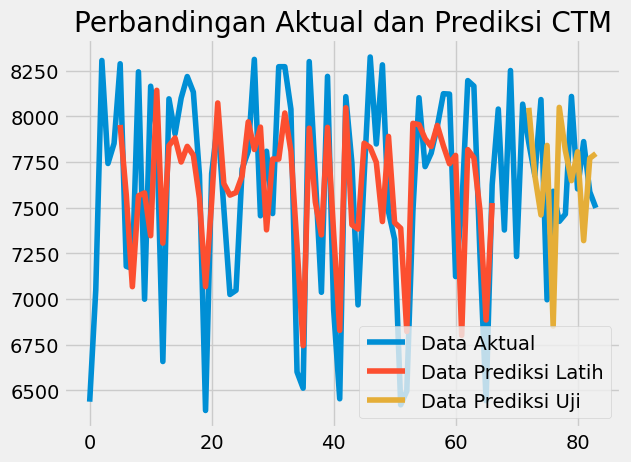

In [22]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict3)+seq_size, :] = trainPredict3

testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict3)+(seq_size*2):len(df), :] = testPredict3

plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.title('Perbandingan Aktual dan Prediksi CTM')
plt.legend(['Data Aktual', 'Data Prediksi Latih', 'Data Prediksi Uji'])
plt.show()

In [23]:
# Save Model
save_model = model3.save('model/model_ctm.h5',save_format='h5')
save_model